In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time

In [2]:
# Conductivity values are from https://www.angstromsciences.com/elements-electrical-conductivity
df = pd.read_excel("../../data/hammerfeld_criterion/Elemental_conductivities.xlsx")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88 entries, 0 to 87
Data columns (total 8 columns):
Electrical Conductivity Ang        79 non-null float64
conductivity_unit1                 86 non-null object
Name                               88 non-null object
Symbol                             88 non-null object
#                                  88 non-null int64
Electrical Conductivity Wolfram    78 non-null float64
conductivity_unit2                 86 non-null object
Note                               1 non-null object
dtypes: float64(2), int64(1), object(5)
memory usage: 5.6+ KB


In [3]:
df['log_cond'] = np.log10(df['Electrical Conductivity Wolfram'])
df.head()

,Electrical Conductivity Ang,conductivity_unit1,Name,Symbol,#,Electrical Conductivity Wolfram,conductivity_unit2,Note,log_cond
0,NaN,NaN,Hydrogen,H,1,NaN,NaN,NaN,NaN
1,NaN,NaN,Helium,He,2,NaN,NaN,NaN,NaN
2,1.080000e-01,10^6/cm,Lithium,Li,3,1.100000e+07,1/m Ω,NaN,7.041393
3,3.130000e-01,10^6/cm Ω,Beryllium,Be,4,2.500000e+07,1/m Ω,NaN,7.397940
4,1.000000e-12,10^6/cm Ω,Boron,B,5,1.000000e-04,1/m Ω,NaN,-4.000000


In [4]:
df = df.dropna(subset=['log_cond'])

In [5]:
df.describe()

,Electrical Conductivity Ang,#,Electrical Conductivity Wolfram,log_cond
count,7.600000e+01,78.000000,7.800000e+01,78.000000
mean,9.066608e-02,49.500000,8.973115e+06,5.750734
std,1.258432e-01,25.498536,1.230190e+07,3.669199
min,5.000000e-24,3.000000,1.000000e-15,-15.000000
25%,1.165000e-02,28.250000,1.225000e+06,6.087872
50%,4.850000e-02,49.500000,4.900000e+06,6.690106
75%,1.107500e-01,70.750000,1.175000e+07,7.069734
max,6.300000e-01,94.000000,6.200000e+07,7.792392


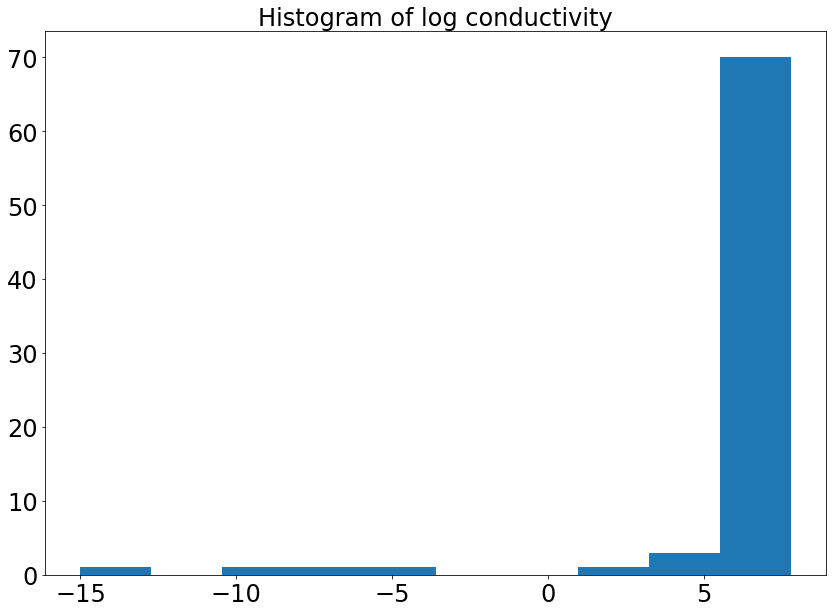

In [6]:
fontsize = 24
fig, ax = plt.subplots(figsize=(14,10))
df.hist(ax=ax, column='log_cond', grid=False)
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(fontsize)
plt.title('Histogram of log conductivity', fontsize=24)
plt.show()

In [7]:
df['metallic'] = df['log_cond'].apply(lambda x: np.where(x <= 5.0, 0, 1))
df.head()

,Electrical Conductivity Ang,conductivity_unit1,Name,Symbol,#,Electrical Conductivity Wolfram,conductivity_unit2,Note,log_cond,metallic
2,1.080000e-01,10^6/cm,Lithium,Li,3,1.100000e+07,1/m Ω,NaN,7.041393,1
3,3.130000e-01,10^6/cm Ω,Beryllium,Be,4,2.500000e+07,1/m Ω,NaN,7.397940,1
4,1.000000e-12,10^6/cm Ω,Boron,B,5,1.000000e-04,1/m Ω,NaN,-4.000000,0
5,6.100000e-04,10^6/cm Ω,Carbon,C,6,1.000000e+05,1/m Ω,Graphite,5.000000,0
6,2.100000e-01,10^6/cm Ω,Sodium,Na,11,2.100000e+07,1/m Ω,NaN,7.322219,1


# Featurize elements

In [8]:
from matminer.featurizers.conversions import StrToComposition
df = StrToComposition().featurize_dataframe(df, 'Symbol')

In [9]:
from matminer.featurizers.composition import ElementProperty

ep_feat = ElementProperty.from_preset(preset_name="magpie")
df = ep_feat.featurize_dataframe(df, col_id="composition", ignore_errors=True)
df.to_csv("../../data/hammerfeld_criterion/featurized_elements.csv",index=False)
df.head()

,Electrical Conductivity Ang,conductivity_unit1,Name,Symbol,#,Electrical Conductivity Wolfram,conductivity_unit2,Note,log_cond,metallic,...,MagpieData range GSmagmom,MagpieData mean GSmagmom,MagpieData avg_dev GSmagmom,MagpieData mode GSmagmom,MagpieData minimum SpaceGroupNumber,MagpieData maximum SpaceGroupNumber,MagpieData range SpaceGroupNumber,MagpieData mean SpaceGroupNumber,MagpieData avg_dev SpaceGroupNumber,MagpieData mode SpaceGroupNumber
2,1.080000e-01,10^6/cm,Lithium,Li,3,1.100000e+07,1/m Ω,NaN,7.041393,1,...,0.0,0.0,0.0,0.0,229.0,229.0,0.0,229.0,0.0,229.0
3,3.130000e-01,10^6/cm Ω,Beryllium,Be,4,2.500000e+07,1/m Ω,NaN,7.397940,1,...,0.0,0.0,0.0,0.0,194.0,194.0,0.0,194.0,0.0,194.0
4,1.000000e-12,10^6/cm Ω,Boron,B,5,1.000000e-04,1/m Ω,NaN,-4.000000,0,...,0.0,0.0,0.0,0.0,166.0,166.0,0.0,166.0,0.0,166.0
5,6.100000e-04,10^6/cm Ω,Carbon,C,6,1.000000e+05,1/m Ω,Graphite,5.000000,0,...,0.0,0.0,0.0,0.0,194.0,194.0,0.0,194.0,0.0,194.0
6,2.100000e-01,10^6/cm Ω,Sodium,Na,11,2.100000e+07,1/m Ω,NaN,7.322219,1,...,0.0,0.0,0.0,0.0,229.0,229.0,0.0,229.0,0.0,229.0


# Remove features with 0 variance

In [10]:
def remove_redundant_features(X):
    """Drops zero variance and highly correlated features from DataFrame."""
    variances = X.var()
    backup = X['MagpieData minimum Number'].copy()
    to_drop = [column for column in variances.index if variances[column] == 0]
    X.drop(columns=to_drop, inplace=True)
    
    # Create correlation matrix
    corr_matrix = X.corr().abs() # Remove text variables before finding correlations

    # Select upper triangle of correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

    # Find index of feature columns with correlation greater than 0.97
    to_drop = [column for column in upper.columns if any(upper[column] > 0.97)]

    X.drop(columns=to_drop, inplace=True)
    
    # Manually keep atomic numbers
    X['MagpieData minimum Number'] = backup
    
    return X

In [11]:
df = remove_redundant_features(df)
df.head()

,Electrical Conductivity Ang,conductivity_unit1,Name,Symbol,#,conductivity_unit2,Note,log_cond,metallic,composition,...,MagpieData minimum NsUnfilled,MagpieData minimum NpUnfilled,MagpieData minimum NdUnfilled,MagpieData minimum NfUnfilled,MagpieData minimum NUnfilled,MagpieData minimum GSvolume_pa,MagpieData minimum GSbandgap,MagpieData minimum GSmagmom,MagpieData minimum SpaceGroupNumber,MagpieData minimum Number
2,1.080000e-01,10^6/cm,Lithium,Li,3,1/m Ω,NaN,7.041393,1,(Li),...,1.0,0.0,0.0,0.0,1.0,16.593333,0.000,0.0,229.0,3.0
3,3.130000e-01,10^6/cm Ω,Beryllium,Be,4,1/m Ω,NaN,7.397940,1,(Be),...,0.0,0.0,0.0,0.0,0.0,7.890000,0.000,0.0,194.0,4.0
4,1.000000e-12,10^6/cm Ω,Boron,B,5,1/m Ω,NaN,-4.000000,0,(B),...,0.0,5.0,0.0,0.0,5.0,7.172500,1.524,0.0,166.0,5.0
5,6.100000e-04,10^6/cm Ω,Carbon,C,6,1/m Ω,Graphite,5.000000,0,(C),...,0.0,4.0,0.0,0.0,4.0,5.640000,4.496,0.0,194.0,6.0
6,2.100000e-01,10^6/cm Ω,Sodium,Na,11,1/m Ω,NaN,7.322219,1,(Na),...,1.0,0.0,0.0,0.0,1.0,29.243333,0.000,0.0,229.0,11.0


# Run classifier model to predict metallicity

In [12]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import scipy.stats

def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, h

def get_scores(X, y, model, metric, test_size=0.15):
    """Computes a model metric across CV runs."""
    scores = []
    for seed in range(10):
        X_train, X_test, y_train, y_test = train_test_split(
            X.drop(columns=['Symbol']), y, test_size=test_size, random_state=seed)
        model.fit(X_train, y_train)

        # Estimate score
        y_pred = model.predict(X_test)
        score = metric(y_test, y_pred)
        scores.append(score)
        
    return scores

In [13]:
X = df.drop(columns=['Electrical Conductivity Ang',
                     'conductivity_unit1',
                     'Name',
                     '#',
                     'conductivity_unit2',
                     'Note',
                     'composition', 
                     'log_cond',
                     'metallic'])
y = df.loc[:, 'metallic']

## Access accuracy across 10 different runs using 20% of data as test set

In [14]:
# Function for hyperparameter selection
from sklearn.model_selection import GridSearchCV
def grid_search(model):
    """Conducts grid search to find optimal model hyperparameters for all 3 classes."""
    param_grid = {'n_estimators': [10, 20, 40, 80, 100, 150, 200], 
                 'max_depth': [2, 3, 5],
                 'learning_rate': np.logspace(-3, 2, num=6)
                 }
    xgb = GridSearchCV(model, param_grid, cv=5, n_jobs=8)
    X_train, X_test, y_train, y_test = train_test_split(
    X.drop(columns=['Symbol']), y, test_size=0.2)
    t0 = time.time()
    xgb.fit(X_train, y_train)
    xgb_fit = time.time() - t0
    print("XGB hyperparameters selected in %.3f s"
          % (xgb_fit))
    params = xgb.best_params_
    return params

In [15]:
model = GradientBoostingClassifier()
best_params = grid_search(model)
print(best_params)
model = GradientBoostingClassifier(**best_params)

XGB hyperparameters selected in 4.571 s
{'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 80}


/home/nicholas/Downloads/scikit-learn/sklearn/model_selection/_search.py:803: DeprecationWarning:

The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.



In [16]:
scores = get_scores(X, y, model, metric=accuracy_score, test_size=0.75)
print(scores)
mean, conf_interval = mean_confidence_interval(scores, confidence=0.95)
print('Mean accuracy: {:0.2f}+/-{:0.2f}'.format(mean, conf_interval))

[0.9152542372881356, 0.9152542372881356, 0.9661016949152542, 0.9830508474576272, 0.9322033898305084, 0.8305084745762712, 0.9322033898305084, 0.9491525423728814, 0.8813559322033898, 0.8813559322033898]
Mean accuracy: 0.92+/-0.03


In [17]:
def plot_train_test(X, y, test_size=0.15, seed=2, figsize=(6, 8), dpi=150, s=12, labelsize=16):
    """Trains metallicity model and scatter plots predictions.
    
    Args:
        X (pandas Dataframe): input features
        y (pandas Dataframe): ground truth labels of metallicity
        test_size (Float): portion of data set aside for testing, remainder will be trained on
        seed (Integer): random seed for shuffling data
        figsize (Tuple): dimensions of output figure
        dpi (Integer): dots per inch resolution of figure
        s (Integer): size of dots in scatter plot
        labelsize (Integer): fontsize for names of elements
    """
    X_train, X_test, y_train, y_test = train_test_split(
            X.drop(columns=['Symbol']), y, test_size=test_size, random_state=seed)
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    
    # Plot training set
    fig = plt.figure(figsize=figsize, dpi=dpi)
    plt.scatter(y_train, X_train['MagpieData minimum Number'], s=s)
    
    # Plotting utility function
    def plot_subset(mask):
        X_subset = X_test['MagpieData minimum Number'].values[mask]
        y_subset = y_test.values[mask]
        plt.scatter(y_subset, X_subset, s=s)
        labels = [X.loc[X['MagpieData minimum Number'] == x, 'Symbol'].values[0] for x in X_subset]
        for i, txt in enumerate(labels):
            plt.annotate(labels[i], 
                         (y_subset[i], X_subset[i]),
                        fontsize=labelsize,
                        ha='right',
                        va='center',
                        xytext=(-4, 0),
                        textcoords='offset points')
            
    # Plot correctly predicted elements in test set
    mask = np.equal(y_test.values, predictions)
    plot_subset(mask)
    
    # Plot incorrectly predicted elements in test set
    mask = np.invert(mask)
    plot_subset(mask)
    
    plt.axis("tight")
    plt.ylabel("Atomic Number", fontsize=24)
    plt.xlabel("True Metallicity", fontsize=24)
    plt.tick_params(axis='both', which='major', labelsize=24)
    plt.legend(['Training', 'Test_correct', 'Test_wrong'])
    plt.show()

## Plot which test set elements are gussed correctly and incorrectly

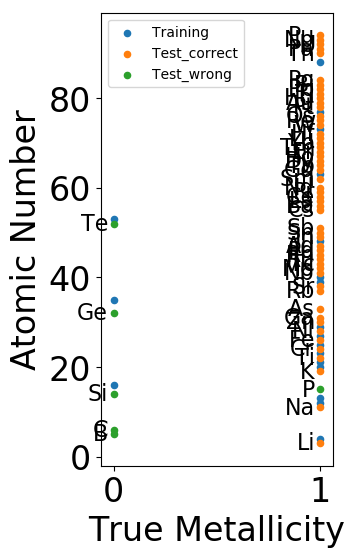

In [18]:
# Play around with seed to change test set
# Increase test size to change difficulty
# It is possible to get near perfect accuracies even with only 1/4 the elements in training!
model = GradientBoostingClassifier(**best_params)
plot_train_test(X, y, test_size=0.75, seed=1, figsize=(3,6), s=20, labelsize=16, dpi=100)

# Phosphorus seems like an outlier...

Turns out Wolfram's value is probably for a particular direction in a single crystal.
A measurement from the 1950's says phosphorus's resistivity is closer to tellurium. https://doi.org/10.1103/PhysRev.92.580
So maybe we should reclassify it.

In [19]:
# Let's correct that and replot
ind = X.loc[X['Symbol'] == 'P'].index  # Get index
y[ind] = 0
model = GradientBoostingClassifier(**best_params)

In [20]:
scores = get_scores(X, y, model, metric=accuracy_score, test_size=0.75)
print(scores)
mean, conf_interval = mean_confidence_interval(scores, confidence=0.95)
print('Mean accuracy: {:0.2f}+/-{:0.2f}'.format(mean, conf_interval))

[0.9152542372881356, 0.9152542372881356, 0.9830508474576272, 1.0, 0.9152542372881356, 0.9322033898305084, 0.9661016949152542, 1.0, 0.8813559322033898, 0.864406779661017]
Mean accuracy: 0.94+/-0.03


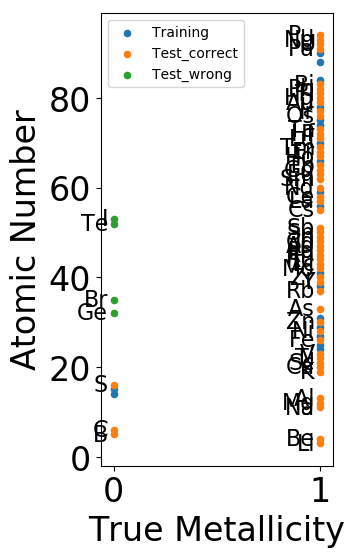

In [21]:
plot_train_test(X, y, test_size=0.75, seed=5, figsize=(3,6), s=20, labelsize=16, dpi=100)

# Use regression to predict log of conductivity

Regression is usually harder than classification

In [22]:
X = df.drop(columns=['Electrical Conductivity Ang',
                     'conductivity_unit1',
                     'Name',
                     '#',
                     'conductivity_unit2',
                     'Note',
                     'composition', 
                     'log_cond',
                     'metallic'])
y = df.loc[:, 'log_cond']

In [23]:
from xgboost import XGBRegressor, plot_importance
from sklearn.metrics import mean_absolute_error, r2_score

# GridSearchCV does not work with this regressor+data combination,
# so use default parameters.
model = XGBRegressor()

maes = get_scores(X, y, model, metric=mean_absolute_error, test_size=0.5)
mean, conf_interval = mean_confidence_interval(maes, confidence=0.95)
print('Mean mean absolute error: {:0.2f}+/-{:0.2f}'.format(mean, conf_interval))
r2s = get_scores(X, y, model, metric=r2_score, test_size=0.5)
mean, conf_interval = mean_confidence_interval(r2s, confidence=0.95)
print("Mean R2 score: {:0.2f}+/-{:0.2f}".format(mean, conf_interval))

Mean mean absolute error: 1.32+/-0.42
Mean R2 score: -1.07+/-1.63


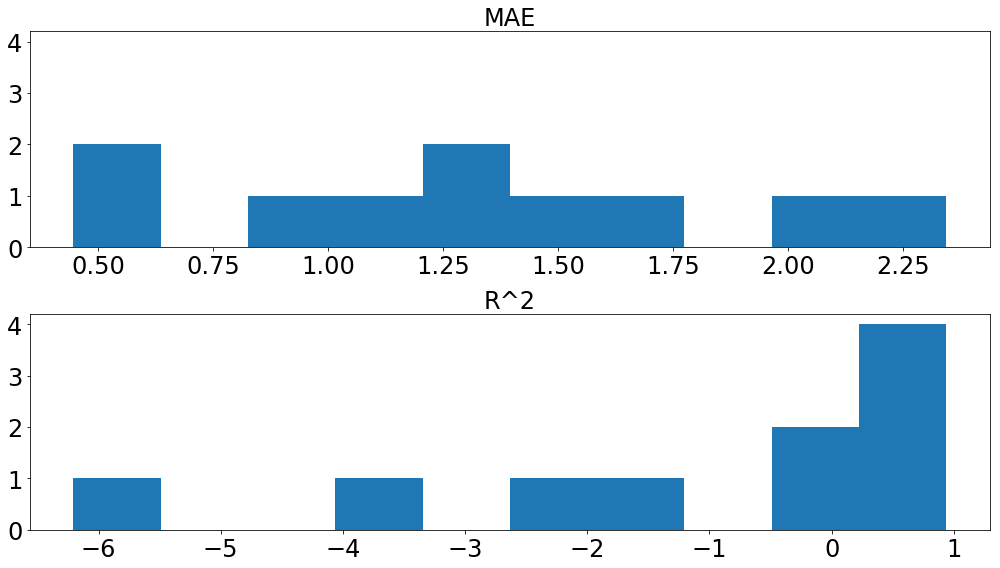

In [24]:
fig, axarr = plt.subplots(nrows=2, figsize=(14,8), sharey=True)
plt.yticks([0, 1, 2, 3, 4])
axarr[0].hist(maes)
axarr[0].set_title('MAE')
oldmaes = maes
axarr[1].hist(r2s)
axarr[1].set_title('R^2')
for ax in axarr:
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                 ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(fontsize)
oldr2s = r2s
plt.tight_layout()
plt.show()

In [25]:
def plot_train_test_regression(X, y, test_size=0.15, seed=2, figsize=(6, 8), dpi=150, s=12, labelsize=16):
    """Trains metallicity model and scatter plots predictions.
    
    Args:
        X (pandas Dataframe): input features
        y (pandas Dataframe): ground truth labels
        test_size (Float): portion of data set aside for testing, remainder will be trained on
        seed (Integer): random seed for shuffling data
        figsize (Tuple): dimensions of output figure
        dpi (Integer): dots per inch resolution of figure
        s (Integer): size of dots in scatter plot
        labelsize (Integer): fontsize for names of elements
    """
    X_train, X_test, y_train, y_test = train_test_split(
            X.drop(columns=['Symbol']), y, test_size=test_size, random_state=seed)
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    predictions = np.reshape(predictions, (len(predictions), 1))
    
    # Plot training set
    fig = plt.figure(figsize=figsize, dpi=dpi)
#     plt.scatter(X_train['MagpieData minimum Number'], y_train, s=s)
    
    # Plot real test values
    plt.scatter(X_test['MagpieData minimum Number'], y_test, s=s)
    x_nums = X_test['MagpieData minimum Number'].values
    labels = [X.loc[X['MagpieData minimum Number'] == x, 'Symbol'].values[0] for x in x_nums]
    for i, txt in enumerate(labels):
        plt.annotate(labels[i], 
                     (x_nums[i], y_test.values[i]),
                    fontsize=labelsize,
                    ha='right',
                    va='center',
                    xytext=(-1.5, 1.5),
                    textcoords='offset points')
    
    # Plot predicted values
    plt.scatter(X_test['MagpieData minimum Number'], predictions, s=s)
    
    plt.ylim([-15.1, 8])
#     plt.axis("tight")
    plt.xlabel("Atomic Number", fontsize=24)
    plt.ylabel("Log conductivity", fontsize=24)
    plt.tick_params(axis='both', which='major', labelsize=24)
    plt.legend(['Test', 'Predictions'])
#     plt.legend(['Training', 'Test', 'Predictions'])
    plt.show()

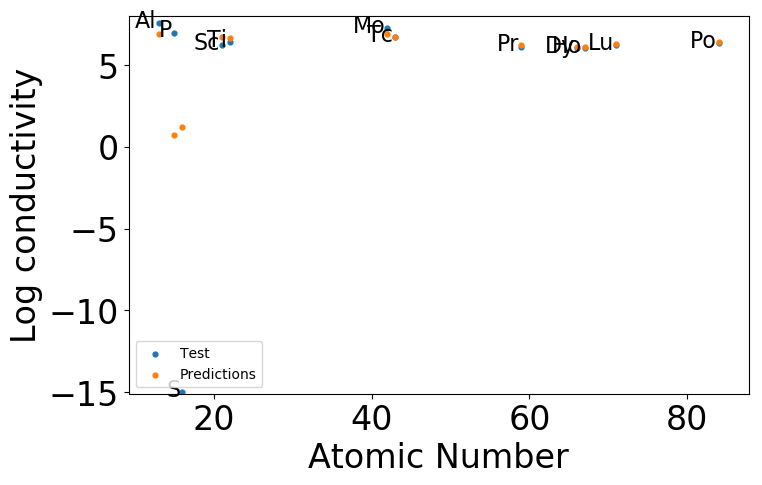

In [27]:
plot_train_test_regression(X, y, test_size=0.15, seed=3, figsize=(8, 5), labelsize=16, dpi=100)

# In Conclusion

Comparing with the predictions using molar refractivity, 